In [208]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso, LassoCV, LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Normalizer
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from glob import glob as glob
import os
import pywt
import cv2
from sklearn.utils.testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning

/Users/Rafferino/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)


In [69]:
num_class = 15
num_train = 20
num_test = 5
im_size = np.array((192, 168))

In [204]:
def filter_files(d, num_train, num_test, cond):
    fnames = [os.path.basename(i)[:-4] for i in glob(d+"/*_P00A*.pgm")]
    acc_files = []
    for f in fnames:
        az = int(f[12:16])
        elev = int(f[17:20])
        if cond(az, elev):
            acc_files.append(f)
    samps = np.random.choice(acc_files, num_train+num_test, replace=False)
    return samps[:num_train], samps[num_train:]

def fread(f):
    return plt.imread(f).flatten().T

def_cond = lambda az, elev: abs(az) <= 45 and abs(elev) <= 45
def train_test_split(num_classes=5, num_train=5, num_test=3, cond = def_cond):
    
    class_dirnames = np.random.choice(glob("CroppedYale/*"), size=num_classes, replace=False)
    
    train_fnames_all, test_fnames_all = np.array([]), np.array([])
    
    A = np.zeros((np.prod(im_size), num_classes*num_train))
    y = np.zeros((np.prod(im_size), num_classes*num_test))
    
    train_gt = np.zeros(num_classes*num_train).astype(int)
    test_gt = np.zeros(num_classes*num_test).astype(int)
    
    for i, d in enumerate(class_dirnames):
        train_fnames, test_fnames = filter_files(d, num_train, num_test, cond)
        train_fnames_all = np.append(train_fnames_all, train_fnames)
        test_fnames_all = np.append(test_fnames_all, test_fnames)
        for j, f in enumerate(train_fnames):
            idx = (i*num_train+j)
            A[:,idx] = fread(d+"/"+f+".pgm")
            train_gt[idx] = i
        for j, f in enumerate(test_fnames):
            idx = (i*num_test+j) 
            y[:,idx] = fread(d+"/"+f+".pgm")
            test_gt[idx] = i
            
    return A, y, train_gt, test_gt, (train_fnames_all, test_fnames_all)

def random_sample():
    all_fnames = glob("*/*/*_P00A*.pgm")
    half = len(all_fnames)//2
    np.random.shuffle(all_fnames)
    
    train_fnames = all_fnames[:half]
    test_fnames = all_fnames[half:]
    
    A = np.zeros((np.prod(im_size), len(train_fnames)))
    y = np.zeros((np.prod(im_size), len(test_fnames)))
    
    train_gt = np.zeros(len(train_fnames)).astype(int)
    test_gt = np.zeros(len(test_fnames)).astype(int)
    
    for i, f in enumerate(train_fnames):
        A[:,i] = fread(f)
        train_gt[i] = int(os.path.basename(f)[5:7])-1
        
    for i, f in enumerate(test_fnames):
        y[:,i] = fread(f)
        test_gt[i] = int(os.path.basename(f)[5:7])-1
        
    return A, y, train_gt, test_gt, (train_fnames, test_fnames)

In [205]:
A, y, train_gt, test_gt, names = random_sample()
print(A.shape, y.shape)
print(train_gt)
print(test_gt)

(32256, 1207) (32256, 1207)
[34 30 23 ...  9 14 22]
[ 7 21  2 ... 38  2 35]


In [198]:
names[1]

['CroppedYale/yaleB05/yaleB05_P00A-085E-20.pgm',
 'CroppedYale/yaleB27/yaleB27_P00A+000E-35.pgm',
 'CroppedYale/yaleB09/yaleB09_P00A+000E-35.pgm',
 'CroppedYale/yaleB06/yaleB06_P00A+025E+00.pgm',
 'CroppedYale/yaleB34/yaleB34_P00A-110E-20.pgm',
 'CroppedYale/yaleB26/yaleB26_P00A+000E+90.pgm',
 'CroppedYale/yaleB26/yaleB26_P00A-005E-10.pgm',
 'CroppedYale/yaleB10/yaleB10_P00A-070E+00.pgm',
 'CroppedYale/yaleB04/yaleB04_P00A-095E+00.pgm',
 'CroppedYale/yaleB04/yaleB04_P00A+110E+40.pgm',
 'CroppedYale/yaleB28/yaleB28_P00A-025E+00.pgm',
 'CroppedYale/yaleB32/yaleB32_P00A+000E+90.pgm',
 'CroppedYale/yaleB07/yaleB07_P00A+050E-40.pgm',
 'CroppedYale/yaleB13/yaleB13_P00A+110E+40.pgm',
 'CroppedYale/yaleB08/yaleB08_P00A+110E+40.pgm',
 'CroppedYale/yaleB33/yaleB33_P00A+050E+00.pgm',
 'CroppedYale/yaleB22/yaleB22_P00A+000E+20.pgm',
 'CroppedYale/yaleB15/yaleB15_P00A-120E+00.pgm',
 'CroppedYale/yaleB28/yaleB28_P00A-010E+00.pgm',
 'CroppedYale/yaleB07/yaleB07_P00A-110E-20.pgm',
 'CroppedYale/yaleB0

In [71]:
A, y, train_gt, test_gt, names = train_test_split(num_classes = num_class, num_train = num_train, num_test = num_test)
print(A.shape, y.shape)
print(train_gt)
print(test_gt)

(32256, 300) (32256, 75)
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  2  3  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  3  3  3  3  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4
  4  4  4  4  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5
  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  7  7  7  7
  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  8  8  8  8  8  8  8  8
  8  8  8  8  8  8  8  8  8  8  8  8  9  9  9  9  9  9  9  9  9  9  9  9
  9  9  9  9  9  9  9  9 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10
 10 10 10 10 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11
 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 13 13 13 13
 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 14 14 14 14 14 14 14 14
 14 14 14 14 14 14 14 14 14 14 14 14]
[ 0  0  0  0  0  1  1  1  1  1  2  2  2  2  2  3  3  3  3  3 

In [72]:
def down_samp(A, ds_factor=16):
    im_size_down = np.ceil(im_size/ds_factor).astype(int)
    A_down = np.zeros((np.prod(im_size_down), A.shape[-1]))
#     print(A_down.shape)
    for i in range(A.shape[-1]):
        A_down[:,i] = A[:,i].reshape(im_size)[::ds_factor, ::ds_factor].flatten()
    return A_down, im_size_down

In [73]:
def down_samp_pca(A, dim=25):
    # sklearn PCA
    pca = PCA(n_components=dim, svd_solver="auto")
    A_pca = pca.fit_transform(A.T).T
    
    # Manual PCA
#     U, S, Vh = np.linalg.svd(A, full_matrices=True)
#     print(U.shape, S.shape, Vh.shape)
#     A_pca = U[:,:dim].T@A
    return A_pca, A_pca.shape

In [74]:
def down_samp_wave(A):
    im_vec = A.reshape((*im_size,-1))
    wave_vec = pywt.wavedec2(im_vec, 'haar', axes=(0,1), level=4)
#     low_dim_data = wave_vec[0]
    low_dim_data = wave_vec[0] + sum(wave_vec[1])
    return low_dim_data.reshape(-1, A.shape[-1]), low_dim_data.shape[:2]

In [157]:
def down_samp_cv(A):
    A_down = np.zeros((120, A.shape[-1]))
    for i in range(A.shape[-1]):
        A_down[:,i] = cv2.resize(A[:,i].reshape(im_size), (12,10)).flatten()
    return A_down, (12,10)

In [165]:
A_ds, ds_shape = down_samp(A, ds_factor=16)

In [76]:
A_wave, wave_shape = down_samp_wave(A)

In [158]:
A_ds_cv, ds_cv_shape = down_samp_cv(A)

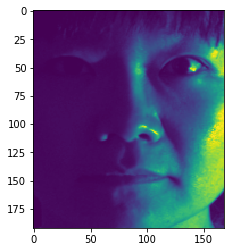

In [163]:
plt.imshow(A[...,0].reshape(im_size))

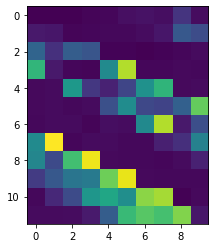

In [164]:
plt.imshow(A_ds_cv[...,0].reshape(ds_cv_shape))

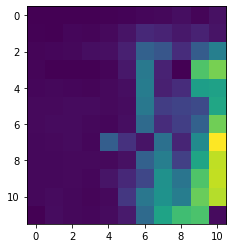

In [167]:
plt.imshow(A_ds[...,0].reshape(ds_shape))

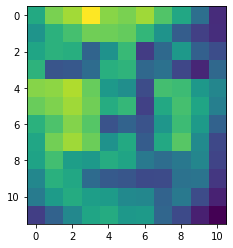

In [78]:
plt.imshow(A_wave[...,3].reshape(wave_shape))

In [79]:
A_pca, pca_shape = down_samp_pca(A)

In [80]:
pca_shape

(25, 300)

In [81]:
A_pca[...,0]

array([-1841.29752769, -2751.60271993, -2934.85384813, -1050.00628289,
         120.96888503,    57.16356056,   596.32752183, -2042.42369256,
        -690.07754528, -1354.95908536,   990.06447436,  -963.16625244,
         174.603189  ,   502.57109557,   478.35513577,   703.21863835,
        -797.1348659 , -1183.54819724,  -787.72365169,  -879.51275366,
         787.04793129,   798.19092376,  -823.41191662,   304.37371321,
        -162.20719012])

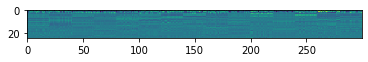

In [82]:
plt.imshow(A_pca)

In [83]:
def delta(x, i):
    assert i < num_class
    out = np.zeros(len(x))
    idxs = slice(i*num_class, i*num_class+num_train)
    out[idxs] = x[idxs]
    return out

In [122]:
def delta_i(x, i, gt):
    return np.where(gt==i, x, 0)

In [186]:
min(test_gt)

0

In [209]:
@ignore_warnings(category=ConvergenceWarning)
def identity(A, y, class_idxs):
    A_norm = np.linalg.norm(A, axis=0)
    y_norm = np.linalg.norm(y)
#     print(A, y)
    prob = Lasso(fit_intercept=False, alpha=1e-4, max_iter=1e3)
#     prob = LassoCV(fit_intercept=False, max_iter=1e4)
    prob.fit(A/A_norm, y/y_norm)
    x_hat = prob.coef_
    r = np.zeros(39)
    for i in range(39):
        r[i] = np.linalg.norm(y-A@delta_i(x_hat, i, class_idxs))
#     print(x_hat)
    return np.argmin(r)

In [92]:
np.linalg.norm(A, axis=0).shape

(300,)

In [93]:
def robust_identity(A, y):
    A = A/np.linalg.norm(A, axis=0)
    y = y/np.linalg.norm(y)
    m,n = A.shape
    B = np.hstack((A, np.eye(m)))
    print(B.shape)
    prob = Lasso(fit_intercept=False)
    prob.fit(B, y)
    w_hat = prob.coef_
    x_hat = w_hat[:n]
    e_hat = w_hat[n:]
    r = np.zeros(L)
    for i in range(L):
        r[i] = np.linalg.norm(y-e_hat-A@delta(x_hat, i))
    print(r-np.min(r))
    return np.argmin(r)

In [214]:
def evaluate(A, y, train_gt, test_gt, ld_func=down_samp):
    train_pred = np.ones_like(train_gt)*-1
    test_pred = np.ones_like(test_gt)*-1
    A_ld, _ = ld_func(A)
    y_ld, _ = ld_func(y)
    
    print(A_ld.shape, y_ld.shape)
    for i in range(len(train_pred)):
        train_pred[i] = identity(A_ld, A_ld[:,i], train_gt)
#         print(train_pred[i], train_gt[i])
    
    for i in range(len(test_pred)):
        try:
            test_pred[i] = identity(A_ld, y_ld[:,i], train_gt)
        except:
            print(y_ld[:,i])
    
#     print(train_pred)
    train_acc = accuracy_score(train_gt, train_pred)
    test_acc = accuracy_score(test_gt, test_pred)
    
    print("Accuracy for {}:\n\tTrain Accuracy: {:.2f}\n\tTest Accuracy: {:.2f}".format(ld_func.__name__, train_acc, test_acc))

In [215]:
down_samp_funcs = [down_samp, down_samp_wave]

In [216]:
for func in down_samp_funcs:
    evaluate(A, y, train_gt, test_gt, ld_func=func)

(132, 1207) (132, 1207)
Accuracy for down_samp:
	Train Accuracy: 1.00
	Test Accuracy: 0.91
(132, 1207) (132, 1207)
Accuracy for down_samp_wave:
	Train Accuracy: 1.00
	Test Accuracy: 0.91


In [ ]:
y_test_noise = fread(test_fnames[2])[:,None]+np.random.normal(scale=500, size=(32256,1))

In [ ]:
plt.imshow(y_test_noise.reshape(im_size))

In [ ]:
robust_identity(A_down, down_samp(y_test_noise,16)[0])